In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import sys
from collections import defaultdict 
import jax
import flax
import chex
from jaxtyping import ArrayLike
from typing import Union, TypeVar
import numpy as np
import matplotlib.pyplot as plt
import traceback
import jax.numpy as jnp

from tracr.compiler.validating import validate
from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler.assemble import AssembledTransformerModel
from tracr.compiler.craft_model_to_transformer import NoTokensError
from tracr.compiler.basis_inference import InvalidValueSetError
from tracr.compiler import rasp_to_graph


from decompile_tracr.dataset import lib
from decompile_tracr.dataset import data_utils
from decompile_tracr.dataset import config
from decompile_tracr.dataset import compile as comp
from decompile_tracr.tokenizing import tokenizer
from decompile_tracr.tokenizing import vocab
from decompile_tracr.sampling import sampling
from decompile_tracr.sampling import rasp_utils


rng = np.random.default_rng(0)

In [2]:
import pandas as pd

In [14]:
data = pd.read_csv('/home/lauro/downloads/all_systems.csv')
openai_data = data[data['Organization'] == "OpenAI"]
openai_data["System"]

KeyError: 'GPT'

In [8]:
openai_data[]

,System,Domain,Organization,Authors,Publication date,Reference,Link,Citations,Notability criteria,Notability criteria notes,...,Dataset accessibility,Code accessibility,Hardware utilization,Finetune compute (FLOP),Finetune compute notes,Batch size,Compute cost notes,Training cloud compute vendor,Batch size notes,Training data center
8,iGPT-L,"Image generation,Vision",OpenAI,"Mark Chen, Alec Radford, Rewon Child, Jeff Wu,...",2020-06-17,Generative Pretraining from Pixels,https://openai.com/blog/image-gpt/,1190.0,Highly cited,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,GPT,Language,OpenAI,"A Radford, K Narasimhan, T Salimans, I Sutskever",2018-06-01,Improving Language Understanding by Generative...,https://openai.com/blog/language-unsupervised/,8064.0,Highly cited,NaN,...,Open source,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,OpenAI Five Rerun,Games,OpenAI,"Christopher Berner, Greg Brockman, Brooke Chan...",2019-12-13,Dota 2 with Large Scale Deep Reinforcement Lea...,https://cdn.openai.com/dota-2.pdf,1420.0,"Highly cited,SOTA improvement","""On April 13th, 2019, OpenAI Five became the f...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
155,Hide and Seek,Games,OpenAI,"B Baker, I Kanitscheider, T Markov, Y Wu",2019-09-17,Emergent Tool Use From Multi-Agent Autocurricula,https://openai.com/blog/emergent-tool-use/,538.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163,GLIDE,Image generation,OpenAI,"Alex Nichol, Prafulla Dhariwal, Aditya Ramesh,...",2021-12-20,GLIDE: Towards Photorealistic Image Generation...,https://arxiv.org/abs/2112.10741,1931.0,Highly cited,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
218,ADM,Image generation,OpenAI,"Prafulla Dhariwal, Alex Nichol",2021-05-11,Diffusion Models Beat GANs on Image Synthesis,https://arxiv.org/abs/2105.05233,3542.0,"Highly cited,SOTA improvement","""We show that diffusion models can achieve ima...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
285,GPT2-Large+LHOPT,Language,OpenAI,"Diogo Almeida, Clemens Winter, Jie Tang, Wojci...",2021-06-02,A Generalizable Approach to Learning Optimizers,https://arxiv.org/abs/2106.00958,21.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
296,Whisper,Speech,OpenAI,"Alec Radford, Jong Wook Kim, Tao Xu, Greg Broc...",2022-09-21,Robust Speech Recognition via Large-Scale Weak...,https://cdn.openai.com/papers/whisper.pdf,1092.0,SOTA improvement,NaN,...,NaN,Open source,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
322,Statement Curriculum Learning,Language,OpenAI,"Stanislas Polu, Jesse Michael Han, Kunhao Zhen...",2022-03-02,Formal Mathematics Statement Curriculum Learning,https://arxiv.org/abs/2202.01344,59.0,SOTA improvement,"""by applying this expert iteration to a manual...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,DALL-E,Image generation,OpenAI,"Aditya Ramesh, Mikhail Pavlov, Gabriel Goh, Sc...",2021-01-05,Zero-Shot Text-to-Image Generation,https://openai.com/blog/dall-e/,2969.0,"Significant use,Highly cited",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# sample, compile, and format for model input

def to_datapoint(program: rasp.SOp):
    tokens = tokenizer.tokenize(program)
    weights = comp.get_weights(tokens, max_weights_len=config.MAX_WEIGHTS_LENGTH)

    datapoint = {
        "tokens": tokens,
        "weights": weights,
        "program_id": 1,
    }

    datapoint = {
        "weights": np.concatenate(datapoint["weights"]).astype(data_utils.NUMPY_DTYPE),
        "tokens": np.concatenate(datapoint["tokens"]).astype(data_utils.NUMPY_DTYPE),
        "program_id": datapoint["program_id"],
    }

    datapoint = data_utils.process_single_datapoint(
        datapoint, 
        d_model=128,
        max_weights_len=config.MAX_WEIGHTS_LENGTH*4,
        max_rasp_len=config.MAX_RASP_LENGTH*4,
    )

    return datapoint


def print_token_legend():
    tokens_to_print = [
        "BOS",
        "EOS",
        "PAD",
        "SelectAggregate",
        "Map",
        "SequenceMap",
    ]
    print("Token Legend:")
    for token in tokens_to_print:
        token_id = vocab.vocab.index(token)
        print(f"{token}: {token_id}")

In [ ]:
m = compiling.compile_rasp_to_model(rasp.Map(lambda x: x + 1, rasp.tokens), vocab=set(range(5)), max_seq_len=5)

In [ ]:
m.params.keys()

dict_keys(['pos_embed', 'token_embed', 'transformer/layer_0/attn/key', 'transformer/layer_0/attn/linear', 'transformer/layer_0/attn/query', 'transformer/layer_0/attn/value', 'transformer/layer_0/mlp/linear_1', 'transformer/layer_0/mlp/linear_2'])

In [ ]:
list(data_utils.layer_names(4))

['embed', 'layer_0/attn', 'layer_0/mlp', 'layer_1/attn', 'layer_1/mlp']

In [ ]:
jax.flatten_util.ravel_pytree([m.params['token_embed'], m.params['pos_embed']])[0].size

221

In [ ]:
program = sampling.sample(rng, program_length=10)
datapoint = to_datapoint(program)


print(datapoint.keys())
print()
print(datapoint['tokens'].shape)
print(datapoint['weights'].shape)
print([str(x) for x in np.unique(datapoint['weights'])])
print()
rasp_utils.print_program(program)
print()
print(datapoint['tokens'])
print()

#plt.imshow(datapoint['weights'], aspect='auto')
#plt.colorbar()

dict_keys(['tokens', 'weights', 'program_id'])

(128,)
(256, 128)
['-350.0', '-349.0', '-250.0', '-249.0', '-150.0', '-149.0', '-50.0', '-49.0', '-2.0', '-1.0', '0.0', '0.05', '1.0', '2.0', '3.0', '4.0', '5.0', '7.0', '9.0', '10.0', '13.0', '17.0', '50.0', '100.0']

map_367 = Map(lambda x: x, indices)    # type: float
sequence_map_368 = SequenceMap(lambda x, y: x * y, tokens, indices)    # type: categorical
map_370 = Map(lambda x: x > 3.5, map_367)    # type: bool
map_372 = Map(lambda x: int(x), map_367)    # type: categorical
map_369 = Map(lambda x: x + 1, sequence_map_368)    # type: float
select_396 = Select(map_372, tokens, predicate=Comparison.NEQ)
linear_sequence_map_381 = LinearSequenceMap(map_369, map_367, -1, 2)    # type: float
aggregate_395 = Aggregate(select_396, map_370)    # type: float
linear_sequence_map_433 = LinearSequenceMap(aggregate_395, linear_sequence_map_381, -2, 1)    # type: float

[ 6.  7.  6. 49. 48. 14. 31. 23. 17. 50. 22. 20. 24. 74. 23.  7.  6.  7.
  6. 6

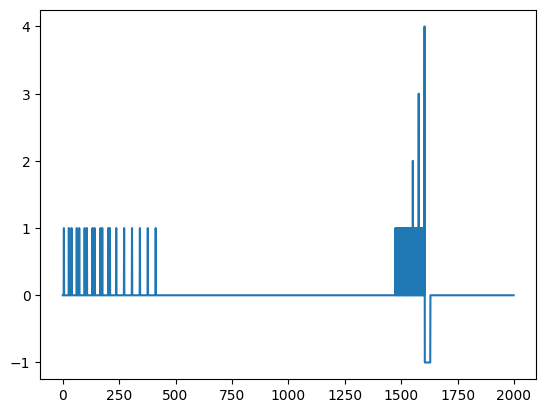

In [ ]:
plt.plot(datapoint['weights'].flatten()[:2000])

['0.0', '0.05', '1.0', '50.0', '100.0']


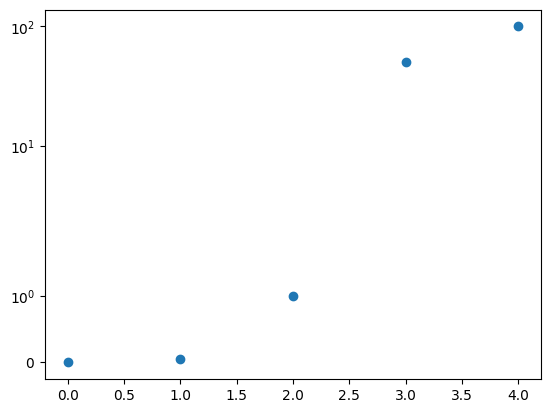

In [ ]:
plt.plot(np.unique(datapoint['weights']), 'o')
plt.yscale('symlog')
print([str(x) for x in np.unique(datapoint['weights'])])

In [ ]:
# SequenceMaps consist of {-1, 0, 1}s
# SelectAggregates have 100s

In [ ]:
print_token_legend()

Token Legend:
BOS: 6
EOS: 7
PAD: 16
SelectAggregate: 18
Map: 14
SequenceMap: 20
